<a href="https://colab.research.google.com/github/Brad1141/ShirtGAN/blob/main/TF_GAN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check that imports for the rest of the file work.
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tensorflow-gan
import tensorflow.compat.v1 as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Allow matplotlib images to render immediately.
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)  # Disable noisy outputs.
#evaluates operations immediately without building graphs

tf.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()

In [3]:
#import shirt data
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
shirtDir = os.listdir("SixDollarImages")
# im = Image.open("SixDollarImages/" + "img1.png")
# print(np.array(im).shape)
# plt.imshow(im)
shirtListTrain = []
shirtListTest = []
index = 0
# for file in shirtDir:
#     im = Image.open("SixDollarImages/" + file)
#     # im = tf.convert_to_tensor(im, dtype=tf.float32)
#     im = tf.convert_to_tensor(im, dtype=tf.uint8)
#     if index < 20:
#         shirtListTrain.append(im)
#     else:
#         # shirtListTest.append(np.asarray(im))
#         shirtListTest.append(im)
#     index = index + 1
#     # plt.imshow(im)

#create tensorflow dataset from images
# @tf.function
# def printStuff():
#     for i in shirtListTrain:
#         print(i)
# printStuff()
    # datasetTrain = tf.data.Dataset.from_tensor_slices(shirtListTrain)
    # datasetTest = tf.data.Dataset.from_tensor_slices(shirtListTest)
# print(datasetTrain)



In [4]:
# import tensorflow_datasets as tfds
# import tensorflow.compat.v1 as tf

# def input_fn(mode, params):

#   # directory = "SixDollarImages/"
#   # ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory + "*.png")))

#   shirtListTrain = []
#   shirtListTest = []
#   index = 0

#   for file in shirtDir:
#     im = Image.open("SixDollarImages/" + file)
#     im = tf.convert_to_tensor(im, dtype=tf.uint8)
#     im = tf.convert_to_tensor(im, dtype=tf.uint8)
#     # im = np.array(im).astype('float32')
#     # im = np.array(im).flatten()
#     if index < 20:
#         shirtListTrain.append(im)
#     else:
#         # shirtListTest.append(np.asarray(im))
#         shirtListTest.append(im)
#     index = index + 1
#     # plt.imshow(im)

#   assert 'batch_size' in params
#   assert 'noise_dims' in params
#   bs = params['batch_size']
#   nd = params['noise_dims']
#   split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
#   shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
#   just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
#   #for each tensor call tf.random_normal
#   #lambda is an unnamed python function 
#   # _ is used to ignore certian values, here we are ignoring the index
#   noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
#               .map(lambda _: tf.random_normal([bs, nd])))
  
#   if just_noise:
#     return noise_ds

#   #private function since _ is in front
#   def _preprocess(element):
#     # print("element")
#     # print(element)
#     # # Map [0, 255] to [-1, 1].
    
#     # images = (tf.cast(element, tf.float32) - 127.5) / 127.5
#     # # images = (tf.cast(element, tf.uint8))
  
#     # return images

#     print("Step 1")
#     print(element)
#     # Map [0, 255] to [-1, 1].
#     images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5

#     print("Step 2")
#     print(images)
#     return images
  
#   #define everything as tensors
#   def process_path(tensorInput):
#     #{'image': <tf.Tensor 'args_0:0' shape=(28, 28, 1) dtype=uint8>, 'label': <tf.Tensor 'args_1:0' shape=() dtype=int64>}
#     #Step 1
#     print("Step 1")
#     print(tensorInput)

#     # print(tf.get_static_value(file_path))
#     # image = tf.io.read_file(file_path)
#     # image = tf.io.decode_png(image, channels=1)
#     # np_images = []

#     # tfString = tf.strings.substr(file_path, pos=0, len=3)
#     # print('tfString')
#     # print(tf.print(tfString))
#     # image = np.array(image)
#     # image = np.array(image, dtype="float32")

#     # image = Image.open(file_path)
#     # image = np.array(image)

#     # for i in image:
#     #   print(i)
#     #   i = ((float(i) - 127.5) / 127.5)
#     #   np_images.append(i)
    
#     # np.reshape(np_images, (512, 512, 1))
#     # print("np images")
#     # print(np_images.shape)

#     image = (tf.cast(tensorInput, tf.float32) - 127.5) / 127.5
#     #Tensor("truediv:0", shape=(28, 28, 1), dtype=float32)
#     #Step 2
#     print("Step 2")
#     print(image)

#     return image

#   # # shirtListTrain = np.array(shirtListTrain).flatten()
#   # # shirtListTest = np.array(shirtListTest).flatten()
#   # print(np.array(shirtListTrain).shape)
#   datasetTrain = tf.data.Dataset.from_tensor_slices(shirtListTrain)
#   datasetTest = tf.data.Dataset.from_tensor_slices(shirtListTest)

#   # TRY
#   # datasetTrainMap = shirtListTrain.map(preprocess)
#   # datasetTrain = tf.data.Dataset.from_tensor_slices(datasetTrainMap)
#   # if split == 'train':
#   #   #returns a map() object (which is an iterator)
#   #   #stores data in a temporary location instead of retrieving from source everytime
#   #   # images_ds = datasetTrain.map(_preprlist(map(lambda x:print(x),datasetTrain))

#   #   # images_ds = datasetTrain.map(process_path)
#   #   images_ds = datasetTrain.map(process_path)
#   #   # images_ds = datasetTrain
      
#   # else:
#   #   images_ds = datasetTest.map(process_path)
#   #   # images_ds = datasetTest.map(process_path)
                
#   images_ds = (tfds.load('mnist:3.*.*', split=split)
#                .map(_preprocess)
#                .cache()
#                .repeat())

#   if shuffle:
#     images_ds = images_ds.shuffle(
#         buffer_size=5, reshuffle_each_iteration=True)
#   images_ds = (images_ds.batch(bs, drop_remainder=True)
#               .prefetch(tf.data.experimental.AUTOTUNE))

#   # <PrefetchDataset shapes: (5, 28, 28, 1), types: tf.float32>
#   # Step 3
#   print("Step 3")
#   print(images_ds)
#   return tf.data.Dataset.zip((noise_ds, images_ds))

import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random_normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    print("Step 1")
    print(element)
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5

    print("Step 2")
    print(images)
    return images

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))
  
  print("Step 3")
  print(images_ds)

  return tf.data.Dataset.zip((noise_ds, images_ds))

Step 1
{'image': <tf.Tensor 'args_0:0' shape=(28, 28, 1) dtype=uint8>, 'label': <tf.Tensor 'args_1:0' shape=() dtype=int64>}
Step 2
Tensor("truediv:0", shape=(28, 28, 1), dtype=float32)
Step 3
<PrefetchDataset shapes: (100, 28, 28, 1), types: tf.float32>


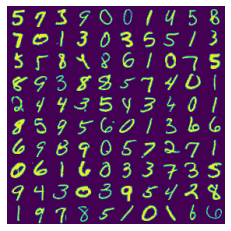

In [5]:
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
# import tensorflow_gan as tfgan
# import numpy as np
# # tf.disable_v2_behavior()

# # print(tf.executing_eagerly())
# #start looking at other datasets and see how they build their datasets

# #do some more reserach on the map() function

# with tf.Graph().as_default():
#   params = {'batch_size': 5, 'noise_dims':16}
#   ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
# #   print(tfds.as_numpy(ds))
#   numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]
# # img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(5, 1))
# # plt.axis('off')
# # plt.imshow(np.squeeze(img_grid))
# # plt.show()

# # for i in numpy_imgs:
# #   # print(i)
# #   im = Image.fromarray(i)
# #   im.show()

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()


### Neural Network Architecture

To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 


In [6]:
def _dense(inputs, units, l2_weight):
  #something wrong with input
  #Tensor("IteratorGetNext:0", shape=(32, 64), dtype=float32, device=/device:CPU:0)
  # units
  # 1024
  # weight
  # 2.5e-05
  #Step 4
  print("Step 4")
  print(inputs)
  print("units")
  print(units)
  print("weight")
  print(l2_weight)

  return tf.layers.Dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight)),

  # return tf.layers.Dense(
  #     units,
  #     kernel_initializer=tf.keras.initializers.glorot_uniform,
  #     kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
  #     bias_regularizer=tf.keras.regularizers.l2(l=l2_weight)),
  

def _batch_norm(inputs, is_training):
  return tf.layers.BatchNormalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)
  # return tf.layers.BatchNormalization(
  #     inputs, momentum=0.999, epsilon=0.001)
      

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.Conv2DTranspose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  # print("input shape")
  # print(inputs.get_shape().as_list())
  return tf.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [7]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):

  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [8]:
#leaky relu: type of activation function which aims to solve the "Dying ReLU problem", it returns a small negative number if (x < 0)
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  # print("disc")
  # print(np.array(img))
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.layers.Flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

### Evaluating Generative Models, and evaluating GANs


TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al for more information about the Inception Score.

*Frechet Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al for more information about the Frechet Inception distance.

In [9]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

### GANEstimator

The `GANEstimator` assembles and manages the pieces of the whole GAN model. The `GANEstimator` constructor takes the following compoonents for both the generator and discriminator:

*  Network builder functions: we defined these in the "Neural Network Architecture" section above.
*  Loss functions: here we use the wasserstein loss for both.
*  Optimizers: here we use `tf.train.AdamOptimizer` for both generator and discriminator training.

In [10]:
#batch size: number of samples propagated through the network during 1 epoch
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

### Train and eval loop

The `GANEstimator`'s `train()` method initiates GAN training, including the alternating generator and discriminator training phases.

The loop in the code below calls `train()` repeatedly in order to periodically display generator output and evaluation results. But note that the code below does not manage the alternation between discriminator and generator: that's all handled automatically by `train()`.

In [11]:

# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 5 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()

Step 1
{'image': <tf.Tensor 'args_0:0' shape=(28, 28, 1) dtype=uint8>, 'label': <tf.Tensor 'args_1:0' shape=() dtype=int64>}
Step 2
Tensor("truediv:0", shape=(28, 28, 1), dtype=float32)
Step 3
<PrefetchDataset shapes: (32, 28, 28, 1), types: tf.float32>
Step 4
Tensor("IteratorGetNext:0", shape=(32, 64), dtype=float32, device=/device:CPU:0)
units
1024
weight
2.5e-05


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Tensor'

### Next steps

Try [this colab notebook](https://github.com/tensorflow/gan) to train a GAN on Google's Cloud TPU use TF-GAN.


